In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [112]:
df_susa = pd.read_csv('susa_valley_20_years_weather.csv')
df_susa['Date'] = pd.to_datetime(df_susa['Date'])
df_susa = df_susa.set_index('Date')
df_susa = df_susa.sort_index()
df_susa.columns = df_susa.columns.str.lower().str.replace(" ", "_")
df_susa['weather_code'] = df_susa['weather_code'].astype('float64')

In [113]:
df_maurienne = pd.read_csv('maurienne_valley_20_years_daily_data.csv')
df_maurienne['Date'] = pd.to_datetime(df_maurienne['Date'])
df_maurienne = df_maurienne.set_index('Date')
df_maurienne = df_maurienne.sort_index()
df_maurienne.columns = df_maurienne.columns.str.lower().str.replace(" ", "_")
df_maurienne['weather_code'] = df_maurienne['weather_code'].astype('float64')

In [114]:
df_merged = df_susa.join(df_maurienne, how="left", lsuffix="_susa", rsuffix="_maurienne")

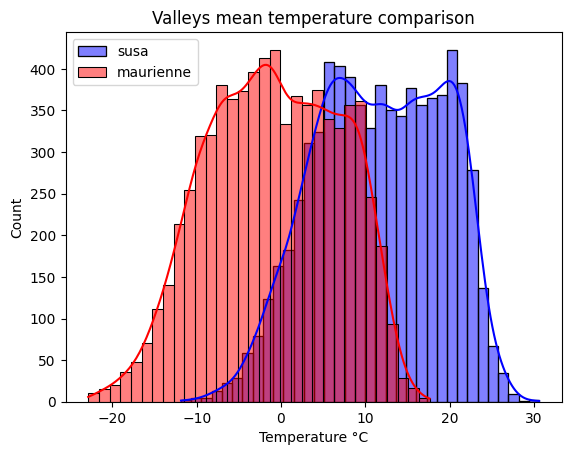

In [115]:
sns.histplot(df_merged, x="mean_temperature_(°c)_susa", kde=True, label="susa", color="blue", alpha=0.5)
sns.histplot(df_merged, x="mean_temperature_(°c)_maurienne", kde=True, label="maurienne", color="red", alpha=0.5)
plt.xlabel('Temperature °C')
plt.title('Valleys mean temperature comparison')
plt.legend()
plt.show()

### Too different climate, each valley requires separate analysis and modelling

In [126]:
#df = df_maurienne.copy()
df = df_susa.copy()

In [127]:
df.describe()

,max_temperature_(°c),min_temperature_(°c),mean_temperature_(°c),avg_relative_humidity_(%),avg_cloud_cover_(%),total_precipitation_(mm),max_wind_speed_(m/s),avg_wind_direction_(°),weather_code
count,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000,7320.000000
mean,15.674235,7.476762,11.719921,74.118852,54.087147,4.180109,7.279617,223.371255,14.322678
std,7.506047,7.404548,7.480920,13.787060,29.442218,8.104580,2.145322,41.390673,24.556812
min,-5.900000,-21.000000,-11.858333,16.500000,0.000000,0.000000,0.800000,40.875000,0.000000
25%,9.700000,2.300000,5.919792,64.875000,30.031250,0.000000,5.800000,199.750000,0.000000
50%,15.900000,7.600000,11.908333,75.750000,54.583333,0.800000,7.000000,223.916667,2.000000
75%,22.000000,13.600000,18.037500,84.625000,79.583333,5.100000,8.400000,251.250000,3.000000
max,35.600000,25.300000,30.625000,99.666667,100.000000,119.400000,21.300000,333.916667,75.000000


In [128]:
df.isnull().sum()

max_temperature_(°c)         0
min_temperature_(°c)         0
mean_temperature_(°c)        0
avg_relative_humidity_(%)    0
avg_cloud_cover_(%)          0
total_precipitation_(mm)     0
max_wind_speed_(m/s)         0
avg_wind_direction_(°)       0
weather_code                 0
dtype: int64

In [129]:
df['weather_code'].value_counts()

weather_code
0.0     2730
3.0     1561
51.0     941
1.0      903
2.0      440
73.0     255
71.0     237
53.0     129
61.0      59
75.0      37
63.0      24
55.0       4
Name: count, dtype: int64

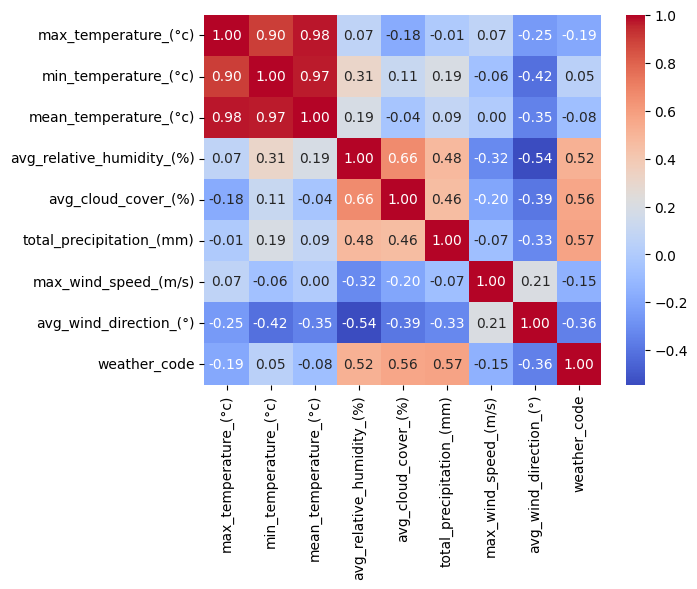

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.show()

Conslusion: weather code is encoeded so that it goes from clear sky to stronger climatic events (cloud -> rain -> snowfall). Therefore it will be treated as a continuous variable

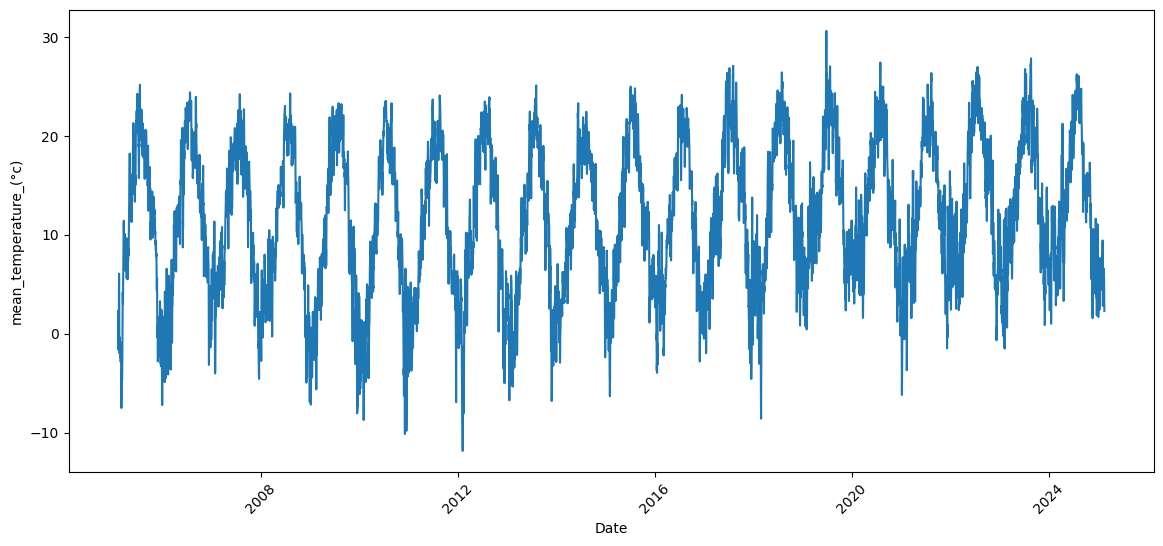

In [131]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='mean_temperature_(°c)')
plt.xticks(rotation=45)
plt.show()

### Group by month year

In [ ]:
df.index = pd.to_datetime(df.index)
df = df.resample('M').mean()
df.index = df.index.strftime('%Y-%m-01')
df.index = pd.to_datetime(df.index)

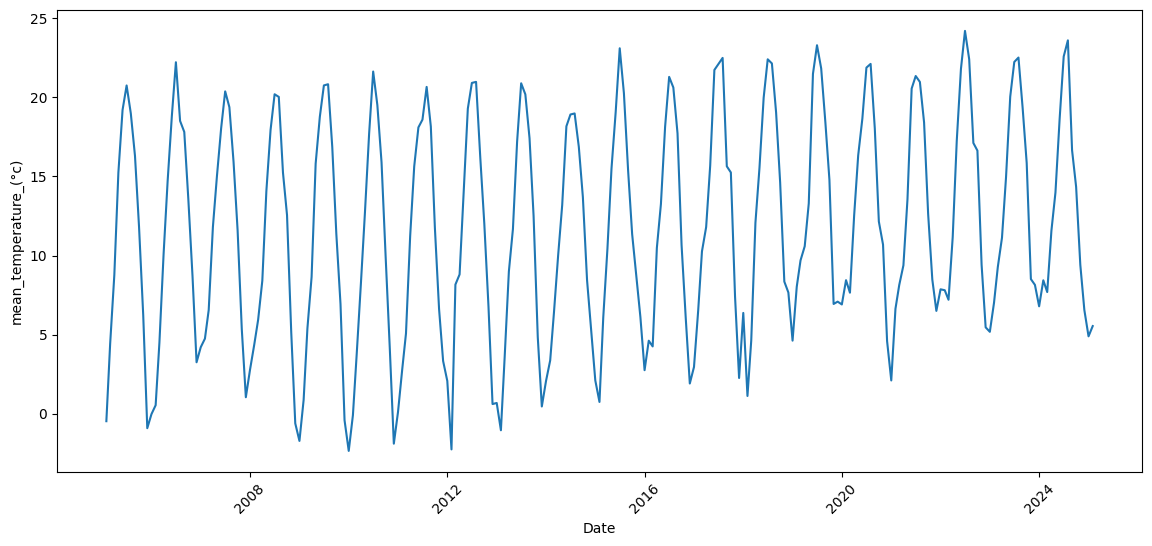

In [133]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x=df.index, y='mean_temperature_(°c)')
plt.xticks(rotation=45)
plt.show()

In [158]:
def decompose(df, col):
    decomposition = sm.tsa.seasonal_decompose(df[col], model='additive', period=12)
    
    # Extract trend, seasonality, and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(df.index, df[col], label='Original')
    plt.legend(loc='best')
    
    plt.subplot(4, 1, 2)
    plt.plot(df.index, trend, label='Trend', color='orange')
    plt.legend(loc='best')
    
    plt.subplot(4, 1, 3)
    plt.plot(df.index, seasonal, label='Seasonality', color='green')
    plt.legend(loc='best')
    
    plt.subplot(4, 1, 4)
    plt.plot(df.index, residual, label='Noise', color='red')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    return trend, seasonal, residual

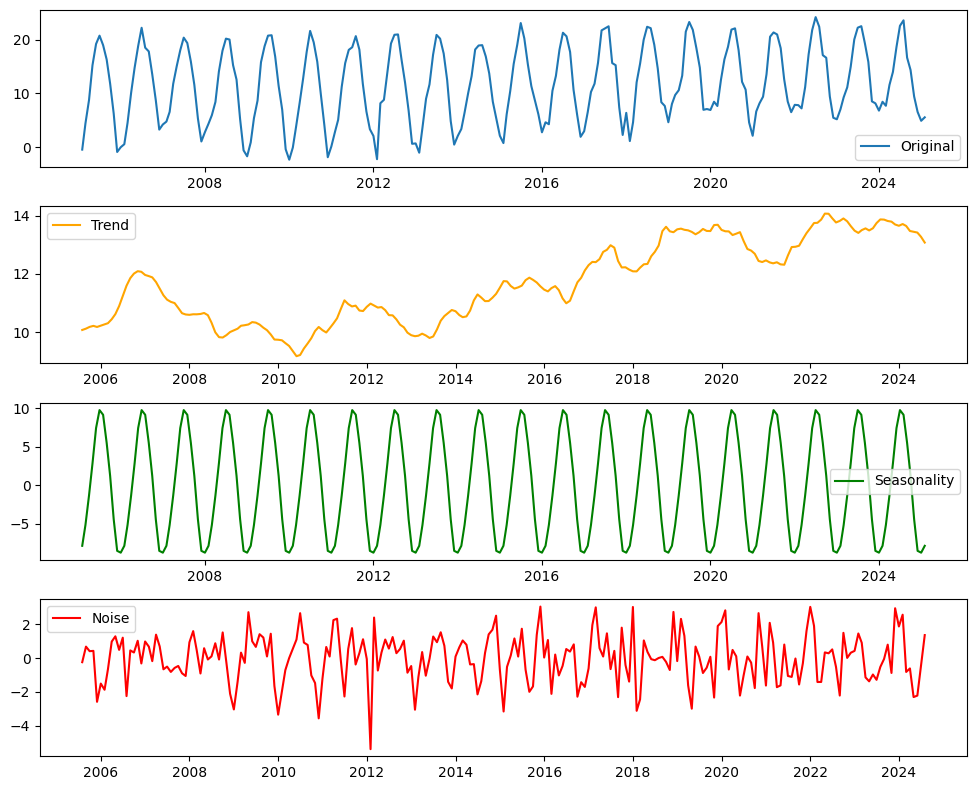

In [160]:
trend, seasonal, residual = decompose(df, 'mean_temperature_(°c)')

In [146]:
seas_mean = seasonal.mean()

In [150]:
seasonal[seasonal > seas_mean].head(15) # hot periods

Date
2005-05-01    2.835724
2005-06-01    7.437275
2005-07-01    9.767529
2005-08-01    9.160130
2005-09-01    5.503005
2005-10-01    1.230617
2006-05-01    2.835724
2006-06-01    7.437275
2006-07-01    9.767529
2006-08-01    9.160130
2006-09-01    5.503005
2006-10-01    1.230617
2007-05-01    2.835724
2007-06-01    7.437275
2007-07-01    9.767529
Name: seasonal, dtype: float64

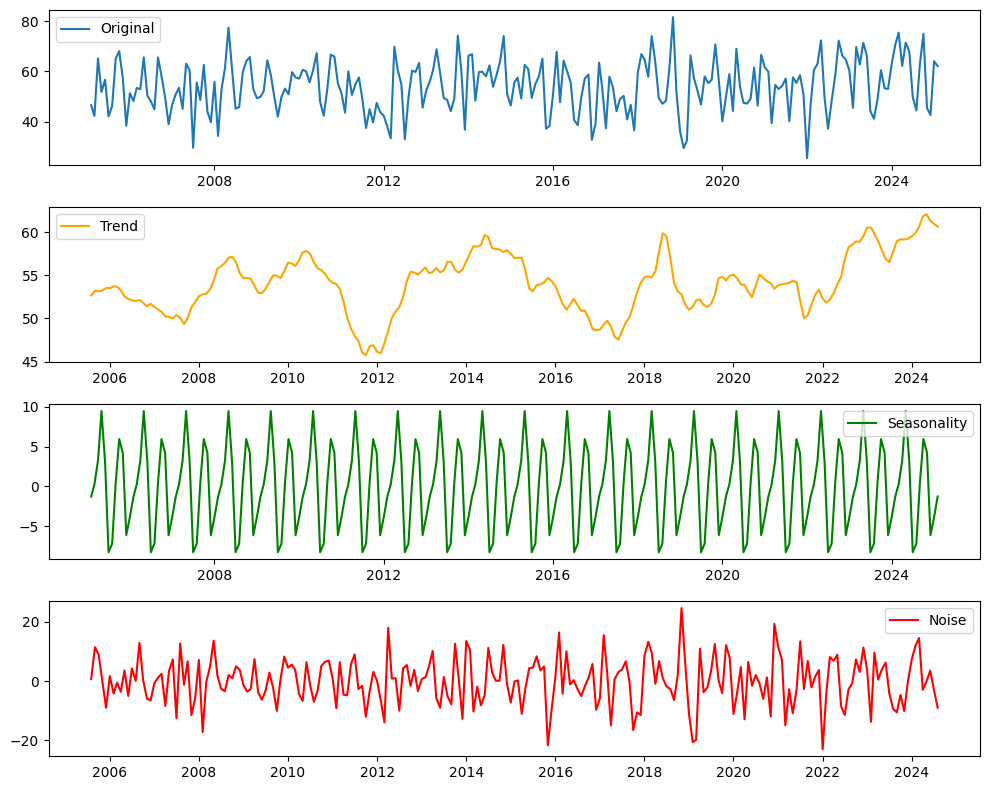

In [162]:
trend, seasonal, residual = decompose(df, 'avg_cloud_cover_(%)')

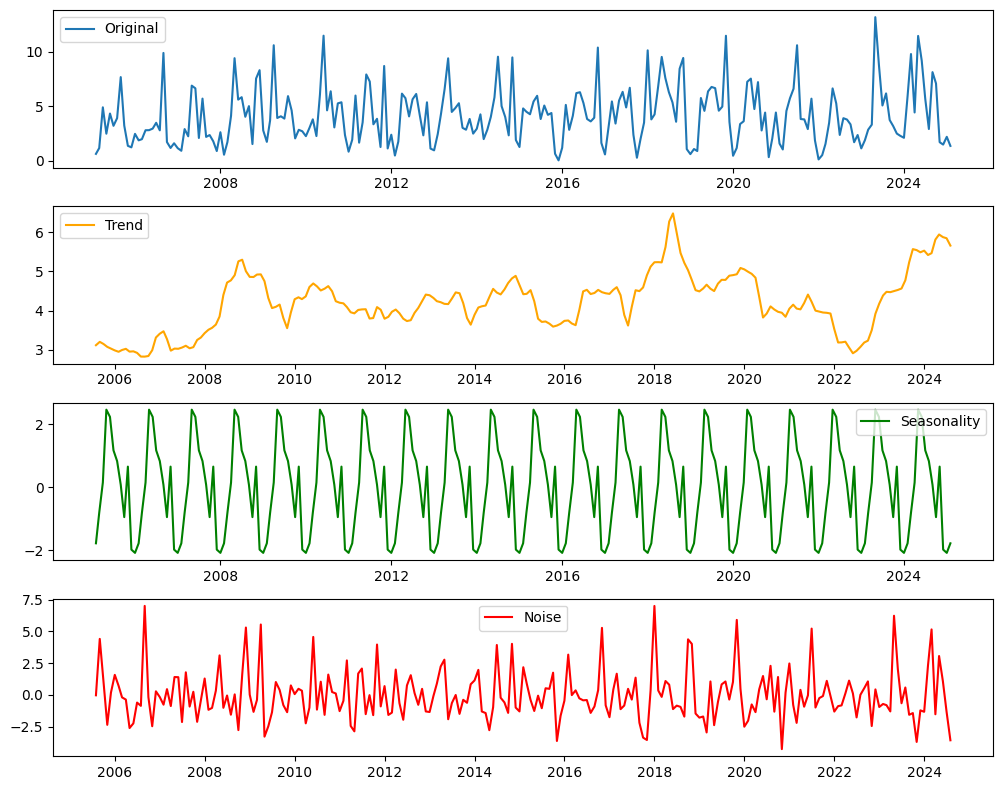

In [163]:
trend, seasonal, residual = decompose(df, 'total_precipitation_(mm)')

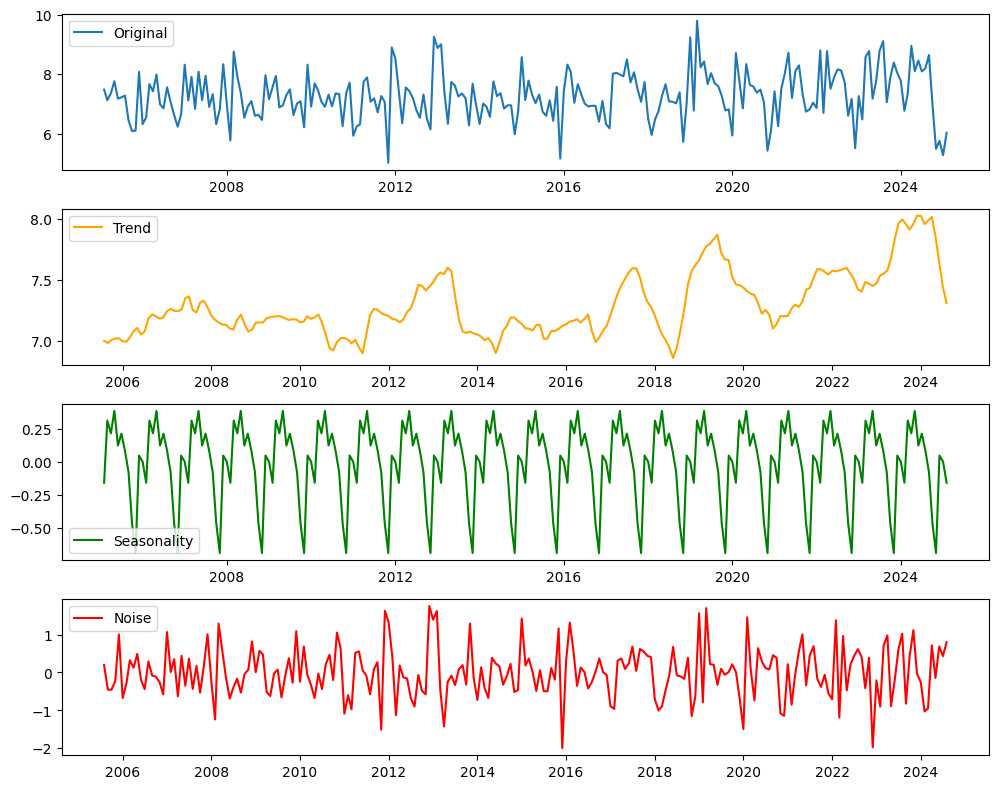

In [164]:
trend, seasonal, residual = decompose(df, 'max_wind_speed_(m/s)')